# 0. 미션 소개 및 주제

### 미션 목표

이번 미션의 최종 목표는 RMSLE (Root Mean Squared Logarithmic Error)를 최대한 낮추는 것입니다. 

다양한 머신러닝 모델과 전략을 실험하여 가장 정확한 수요 예측 모델을 개발하고, 그 결과를 보고서에 담아 보세요!

-> 보고서를 따로 만들지 말고, 노트북을 잘 정리하기

### 미션 방향성


먼저 EDA와 데이터 전처리를 통하여, 데이터를 다듬고, 데이터를 분석한다.

그 다음, 배운 기본 지도 학습 알고리즘인 선형회귀, 다중회귀, 로지스틱회귀(제외), L1, L2정규화를 이용하여

RMSLE를 비교하며 적합한 모델을 직접 확인해보고,

하이퍼 파라미터를 통하여 직접 확인한 수치가 맞는지 비교를 한다.

최종적으로, 적합한 수요 예측 모델로 test 결과를 예측한다.

### 데이터 컬럼 설명

| 컬럼명          | 데이터 타입   | 설명                                                |
| ------------ | -------- | ------------------------------------------------- |
| `datetime`   | datetime | 자전거 대여 기록의 날짜 및 시간<br>예: `2011-01-01 00:00:00`    |
| `season`     | int      | 계절<br>(1: 봄, 2: 여름, 3: 가을, 4: 겨울)                 |
| `holiday`    | int      | 공휴일 여부<br>(0: 평일, 1: 공휴일)                         |
| `workingday` | int      | 근무일 여부<br>(0: 주말/공휴일, 1: 근무일)                     |
| `weather`    | int      | 날씨 상황<br>(1: 맑음, 2: 구름낌/안개, 3: 약간의 비/눈, 4: 폭우/폭설) |
| `temp`       | float    | 실측 온도 (섭씨)                                        |
| `atemp`      | float    | 체감 온도 (섭씨)                                        |
| `humidity`   | int      | 습도 (%)                                            |
| `windspeed`  | float    | 풍속 (m/s)                                          |
| `casual`     | int      | 등록되지 않은 사용자의 대여 수                                 |
| `registered` | int      | 등록된 사용자의 대여 수                                     |
| `count`      | int      | **총 대여 수 (종속 변수)**                                |


### 기본 세팅

In [2]:
# 기본 세팅

# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
import optuna

# 경고 안보이게 하기
import warnings
from scipy.linalg import LinAlgWarning
warnings.filterwarnings("ignore", category=LinAlgWarning)

# 한글 폰트
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 파일 불러오기
test_df = pd.read_csv('test.csv')
train_df = pd.read_csv('train.csv')



# 이번 미션 평가지표 RMSLE 
def rmsle(y_true, y_pred, convertExp=True):
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
    return np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))) # np.power(a, b) : a^b
# y는 log1p 변환값 (log1p : log(1+x))

# rmsle_lr = rmsle(np.expm1(y), np.expm1(pred_gs), convertExp=False)
# print("RMSLE:", rmsle_lr)

c:\Users\wina0\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. EDA

## - 기본 정보 확인

In [3]:
# 기본 정보 확인
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [4]:
# 기본 정보 확인
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [5]:
# 기본 정보 확인
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
# 기본 정보 확인
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [7]:
# 기본 정보 확인
train_df.describe(include='all')

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
unique,10886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2011-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,NaN,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,NaN,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,NaN,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,NaN,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000


In [8]:
# 기본 정보 확인
test_df.describe(include='all')

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
unique,6493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2011-01-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,NaN,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,NaN,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,NaN,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,NaN,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,NaN,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900


## - 결측값 확인

In [9]:
# 결측값 확인
train_df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [10]:
# 결측값 확인
test_df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

## - 중복값 확인

In [11]:
# 중복값 확인
train_df[train_df.duplicated(keep='first')]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count


In [12]:
# 중복값 확인
test_df[test_df.duplicated(keep='first')]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed


- train 데이터와 test 데이터 모두 결측값, 중복값은 없음.

이상치는 데이터 전처리에서 발견시 처리예정




# 2. 데이터 전처리

### 수치형 데이터

In [13]:
# 수치형 데이터
num_features = ['temp','atemp','humidity','windspeed']

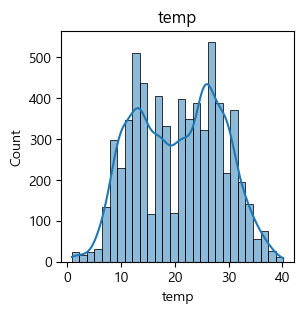

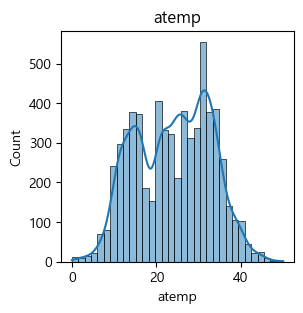

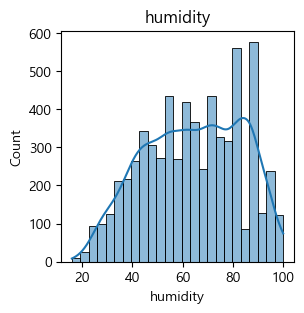

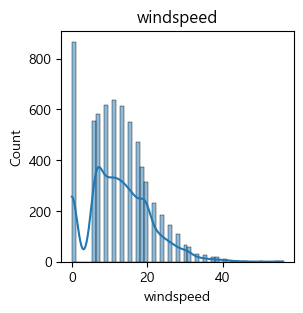

In [14]:
# 시각화
for col in num_features:
    plt.figure(figsize=(3,3))
    sns.histplot(test_df[col], kde=True)
    plt.title(col)
    plt.show()

- windspeed는 분포가 치우쳐져 있어서 안정화를 위해 로그 변환
- 나머지는 표준화 진행

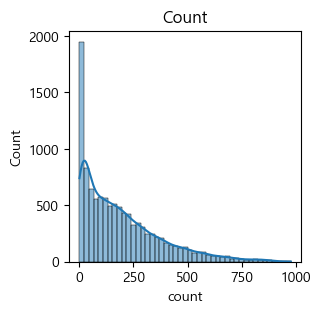

In [15]:
# 목표변수 시각화
plt.figure(figsize=(3,3))
sns.histplot(train_df['count'], kde=True)
plt.title('Count')
plt.show()

- count(목표변수)도 로그 변환

In [16]:
# 로그 변환
train_df['windspeed'] = np.log1p(train_df['windspeed'])
train_df['count'] = np.log1p(train_df['count'])
test_df['windspeed'] = np.log1p(test_df['windspeed'])

# 표준화
standard_scaler = StandardScaler()
standard_features = ['temp', 'atemp', 'humidity']

train_df[standard_features] = standard_scaler.fit_transform(train_df[standard_features])
test_df[standard_features] = standard_scaler.transform(test_df[standard_features])

### 범주형 데이터

In [17]:
# 범주형 데이터 
cat_features = ['season', 'holiday', 'workingday', 'weather']

In [18]:
# 각 데이터 고유값 확인
print(train_df['season'].value_counts())
print(train_df['holiday'].value_counts())
print(train_df['workingday'].value_counts())
print(train_df['weather'].value_counts())

season
4    2734
2    2733
3    2733
1    2686
Name: count, dtype: int64
holiday
0    10575
1      311
Name: count, dtype: int64
workingday
1    7412
0    3474
Name: count, dtype: int64
weather
1    7192
2    2834
3     859
4       1
Name: count, dtype: int64


In [19]:
# weather 4인 데이터량이 부족하여 drop하기
train_df = train_df[train_df['weather'] != 4]
train_df['weather'].value_counts()

weather
1    7192
2    2834
3     859
Name: count, dtype: int64

In [20]:
# 인코딩 
train_encoded_df = pd.get_dummies(train_df, columns=cat_features, drop_first=True)
test_encoded_df = pd.get_dummies(test_df, columns=cat_features, drop_first=True)

In [21]:
# train과 test의 컬럼 불일치를 방지 

train_encoded_df, test_encoded_df = train_encoded_df.align(test_encoded_df, join='left', axis=1, fill_value=0)

### 날짜형 데이터

In [22]:
# 날짜형 데이터 타입 변환
train_encoded_df['datetime'] = pd.to_datetime(train_encoded_df['datetime'])
test_encoded_df['datetime'] = pd.to_datetime(test_encoded_df['datetime'])

In [23]:
# 날짜형 데이터 열 추가

train_encoded_df['year'] = train_encoded_df['datetime'].dt.year
train_encoded_df['month'] = train_encoded_df['datetime'].dt.month
train_encoded_df['day'] = train_encoded_df['datetime'].dt.day
train_encoded_df['hour'] = train_encoded_df['datetime'].dt.hour
train_encoded_df['weekday'] = train_encoded_df['datetime'].dt.weekday

test_encoded_df['year'] = test_encoded_df['datetime'].dt.year
test_encoded_df['month'] = test_encoded_df['datetime'].dt.month
test_encoded_df['day'] = test_encoded_df['datetime'].dt.day
test_encoded_df['hour'] = test_encoded_df['datetime'].dt.hour
test_encoded_df['weekday'] = test_encoded_df['datetime'].dt.weekday  # 시작 요일 : 월(0)

### 분석용 자료 생성

위에서 데이터를 로그변환과 표준화 처리하였기에, 

1. 이를 재변환해서 데이터 분석 하고, 이를 다시 변환한 값을 모델링 하는 것보다

2. 변환한 값 자체의 해석한 내용을 표기하는 것보다

-> 분석용 자료를 만들어서 분석하는게 낫다고 판단.



In [24]:
# 분석용 자료 불러오기
analysis_df = pd.read_csv('train.csv')

analysis_df['datetime'] = pd.to_datetime(analysis_df['datetime'])

analysis_df['year'] = analysis_df['datetime'].dt.year
analysis_df['month'] = analysis_df['datetime'].dt.month
analysis_df['day'] = analysis_df['datetime'].dt.day
analysis_df['hour'] = analysis_df['datetime'].dt.hour
analysis_df['weekday'] = analysis_df['datetime'].dt.weekday

### 적용된 데이터 확인

In [25]:
# 적용된 데이터 확인하기
train_encoded_df.head()

,datetime,temp,atemp,humidity,windspeed,casual,registered,count,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,year,month,day,hour,weekday
0,2011-01-01 00:00:00,-1.333661,-1.092737,0.993213,0.0,3,13,2.833213,False,False,False,False,False,False,False,2011,1,1,0,5
1,2011-01-01 01:00:00,-1.438907,-1.182421,0.941249,0.0,8,32,3.713572,False,False,False,False,False,False,False,2011,1,1,1,5
2,2011-01-01 02:00:00,-1.438907,-1.182421,0.941249,0.0,5,27,3.496508,False,False,False,False,False,False,False,2011,1,1,2,5
3,2011-01-01 03:00:00,-1.333661,-1.092737,0.681430,0.0,3,10,2.639057,False,False,False,False,False,False,False,2011,1,1,3,5
4,2011-01-01 04:00:00,-1.333661,-1.092737,0.681430,0.0,0,1,0.693147,False,False,False,False,False,False,False,2011,1,1,4,5


In [26]:
# 적용된 데이터 확인하기
test_encoded_df.head()

,datetime,temp,atemp,humidity,windspeed,casual,registered,count,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,year,month,day,hour,weekday
0,2011-01-20 00:00:00,-1.228414,-1.450292,-0.305883,3.295937,0,0,0,False,False,False,False,True,False,False,2011,1,20,0,3
1,2011-01-20 01:00:00,-1.228414,-1.182421,-0.305883,0.000000,0,0,0,False,False,False,False,True,False,False,2011,1,20,1,3
2,2011-01-20 02:00:00,-1.228414,-1.182421,-0.305883,0.000000,0,0,0,False,False,False,False,True,False,False,2011,1,20,2,3
3,2011-01-20 03:00:00,-1.228414,-1.271515,-0.305883,2.485023,0,0,0,False,False,False,False,True,False,False,2011,1,20,3,3
4,2011-01-20 04:00:00,-1.228414,-1.271515,-0.305883,2.485023,0,0,0,False,False,False,False,True,False,False,2011,1,20,4,3


In [27]:
# 적용된 데이터 확인하기
train_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10885 entries, 0 to 10885
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      10885 non-null  datetime64[ns]
 1   temp          10885 non-null  float64       
 2   atemp         10885 non-null  float64       
 3   humidity      10885 non-null  float64       
 4   windspeed     10885 non-null  float64       
 5   casual        10885 non-null  int64         
 6   registered    10885 non-null  int64         
 7   count         10885 non-null  float64       
 8   season_2      10885 non-null  bool          
 9   season_3      10885 non-null  bool          
 10  season_4      10885 non-null  bool          
 11  holiday_1     10885 non-null  bool          
 12  workingday_1  10885 non-null  bool          
 13  weather_2     10885 non-null  bool          
 14  weather_3     10885 non-null  bool          
 15  year          10885 non-null  int32      

In [28]:
# 적용된 데이터 확인하기
test_encoded_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   datetime      6493 non-null   datetime64[ns]
 1   temp          6493 non-null   float64       
 2   atemp         6493 non-null   float64       
 3   humidity      6493 non-null   float64       
 4   windspeed     6493 non-null   float64       
 5   casual        6493 non-null   int64         
 6   registered    6493 non-null   int64         
 7   count         6493 non-null   int64         
 8   season_2      6493 non-null   bool          
 9   season_3      6493 non-null   bool          
 10  season_4      6493 non-null   bool          
 11  holiday_1     6493 non-null   bool          
 12  workingday_1  6493 non-null   bool          
 13  weather_2     6493 non-null   bool          
 14  weather_3     6493 non-null   bool          
 15  year          6493 non-null   int32   

In [29]:
# 적용된 데이터 확인하기
train_encoded_df.describe(include='all')

,datetime,temp,atemp,humidity,windspeed,casual,registered,count,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,year,month,day,hour,weekday
count,10885,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000,10885,10885,10885,10885,10885,10885,10885,10885.000000,10885.000000,10885.000000,10885.000000,10885.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,True,False,False,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8152,8152,8151,10574,7411,8051,10026,NaN,NaN,NaN,NaN,NaN
mean,2011-12-27 05:54:35.222783744,0.000142,0.000133,-0.000115,2.327429,36.024713,155.551952,4.591316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.501883,6.522003,9.992650,11.541020,3.014240
min,2011-01-01 00:00:00,-2.491372,-2.701736,-3.215858,0.000000,0.000000,0.000000,0.693147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.000000,1.000000,1.000000,0.000000,0.000000
25%,2011-07-02 07:00:00,-0.807428,-0.824865,-0.773558,2.079629,4.000000,36.000000,3.761200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.000000,4.000000,5.000000,6.000000,1.000000
50%,2012-01-01 20:00:00,0.034544,0.069023,0.005900,2.638914,17.000000,118.000000,4.983607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,7.000000,10.000000,12.000000,3.000000
75%,2012-07-01 13:00:00,0.771270,0.873818,0.785358,2.890255,49.000000,222.000000,5.652489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,10.000000,15.000000,18.000000,5.000000
max,2012-12-19 23:00:00,2.665707,2.572501,1.980526,4.060390,367.000000,886.000000,6.885510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,12.000000,19.000000,23.000000,6.000000


In [30]:
# 적용된 데이터 확인하기
test_encoded_df.describe(include='all')

,datetime,temp,atemp,humidity,windspeed,casual,registered,count,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,year,month,day,hour,weekday
count,6493,6493.000000,6493.000000,6493.000000,6493.000000,6493.0,6493.0,6493.0,6493,6493,6493,6493,6493,6493,6493,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,2,2,2,2,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,True,False,False,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4817,4730,4995,6304,4453,4783,5933,NaN,NaN,NaN,NaN,NaN
mean,2012-01-13 09:27:47.765285632,0.050024,0.042220,0.116334,2.294061,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.503619,6.565070,25.224550,11.555367,3.007239
min,2011-01-20 00:00:00,-2.491372,-2.791420,-2.384437,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.000000,1.000000,20.000000,0.000000,0.000000
25%,2011-07-22 15:00:00,-0.807428,-0.824865,-0.669630,2.079629,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.000000,4.000000,22.000000,6.000000,1.000000
50%,2012-01-20 23:00:00,0.139790,0.158707,0.161792,2.485023,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,7.000000,25.000000,12.000000,3.000000
75%,2012-07-20 17:00:00,0.876516,0.873818,0.993213,2.890255,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,10.000000,28.000000,18.000000,5.000000
max,2012-12-31 23:00:00,2.560460,3.108834,1.980526,4.043027,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012.000000,12.000000,31.000000,23.000000,6.000000


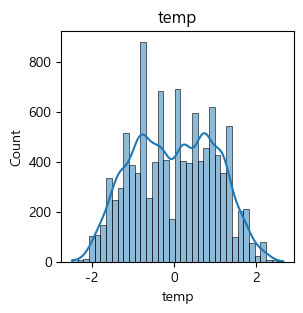

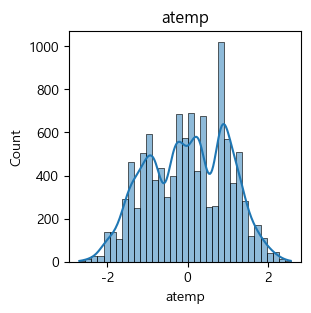

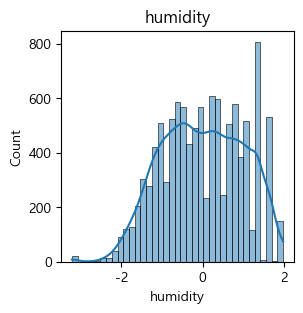

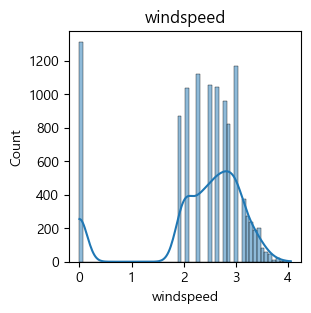

In [31]:
# 적용된 수치형 데이터 시각화
for col in num_features:
    plt.figure(figsize=(3,3))
    sns.histplot(train_encoded_df[col], kde=True)
    plt.title(col)
    plt.show()

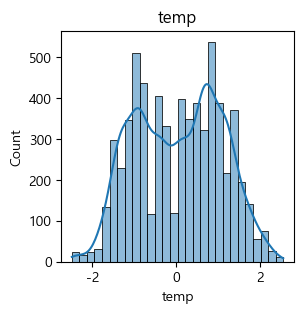

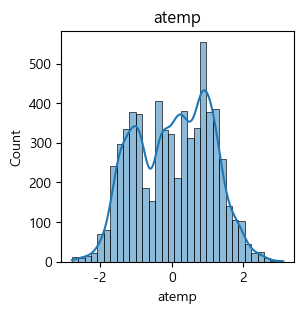

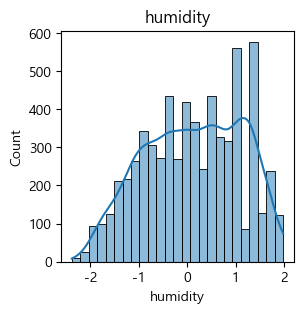

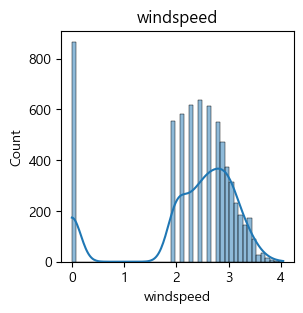

In [32]:
# 적용된 수치형 데이터 시각화
for col in num_features:
    plt.figure(figsize=(3,3))
    sns.histplot(test_encoded_df[col], kde=True)
    plt.title(col)
    plt.show()

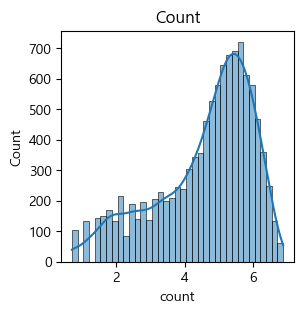

In [33]:
plt.figure(figsize=(3,3))
sns.histplot(train_encoded_df['count'], kde=True)
plt.title('Count')
plt.show()

# 3. 데이터 분석

In [34]:
# 그룹별 평균을 barplot으로 시각화하는 패턴 만들기
def barplot_pattern(df, group_col, target='count', title=''):
    mean = df.groupby(group_col)[target].mean()
    sns.barplot(x=mean.index, y=mean.values)
    plt.title(title)
    plt.show()

### 1. 상관관계 분석

In [35]:
# 상관관계 
corr = train_encoded_df.corr()

corr

,datetime,temp,atemp,humidity,windspeed,casual,registered,count,season_2,season_3,season_4,holiday_1,workingday_1,weather_2,weather_3,year,month,day,hour,weekday
datetime,1.000000,0.181015,0.181849,0.032851,-0.052302,0.172734,0.314879,0.237444,-0.130556,0.122130,0.373918,0.010989,-0.003662,0.026346,-0.027403,0.866604,0.494155,0.028564,-0.005669,-0.004668
temp,0.181015,1.000000,0.984945,-0.064783,0.010197,0.467071,0.318608,0.376682,0.192603,0.635972,-0.266335,0.000270,0.030067,-0.047015,-0.025759,0.061377,0.257420,0.015527,0.145584,-0.038687
atemp,0.181849,0.984945,1.000000,-0.043376,-0.027457,0.462039,0.314668,0.372254,0.204367,0.607081,-0.245795,-0.005238,0.024754,-0.040875,-0.031196,0.058681,0.264016,0.011843,0.140486,-0.040443
humidity,0.032851,-0.064783,-0.043376,1.000000,-0.242230,-0.348149,-0.265479,-0.333226,-0.031031,0.067381,0.129096,0.001949,-0.010960,0.222486,0.295950,-0.078730,0.204760,-0.011315,-0.278150,-0.026338
windspeed,-0.052302,0.010197,-0.027457,-0.242230,1.000000,0.081862,0.090893,0.117463,0.048791,-0.051988,-0.080654,0.001114,0.005648,-0.019820,0.040402,0.005205,-0.116979,0.050408,0.133335,-0.013529
casual,0.172734,0.467071,0.462039,-0.348149,0.081862,1.000000,0.497259,0.579068,0.132377,0.187700,-0.086293,0.043790,-0.319085,-0.062219,-0.108871,0.145305,0.092646,0.014099,0.302114,0.246905
registered,0.314879,0.318608,0.314668,-0.265479,0.090893,0.497259,1.000000,0.792133,0.046971,0.102144,0.056963,-0.020955,0.119461,-0.028997,-0.104936,0.264275,0.169473,0.019111,0.380554,-0.084434
count,0.237444,0.376682,0.372254,-0.333226,0.117463,0.579068,0.792133,1.000000,0.059064,0.119958,0.038043,-0.001225,-0.015350,-0.019171,-0.111516,0.178212,0.163805,0.019014,0.570633,0.027318
season_2,-0.130556,0.192603,0.204367,-0.031031,0.048791,0.132377,0.046971,0.059064,1.000000,-0.335255,-0.335337,-0.038259,0.014657,-0.001718,0.006540,-0.002393,-0.255700,0.001009,-0.002684,-0.000837
season_3,0.122130,0.635972,0.607081,0.067381,-0.051988,0.187700,0.102144,0.119958,-0.335255,1.000000,-0.335337,0.022781,-0.007158,-0.051928,-0.013105,-0.001545,0.248302,0.000932,-0.002561,-0.003585


<Axes: >

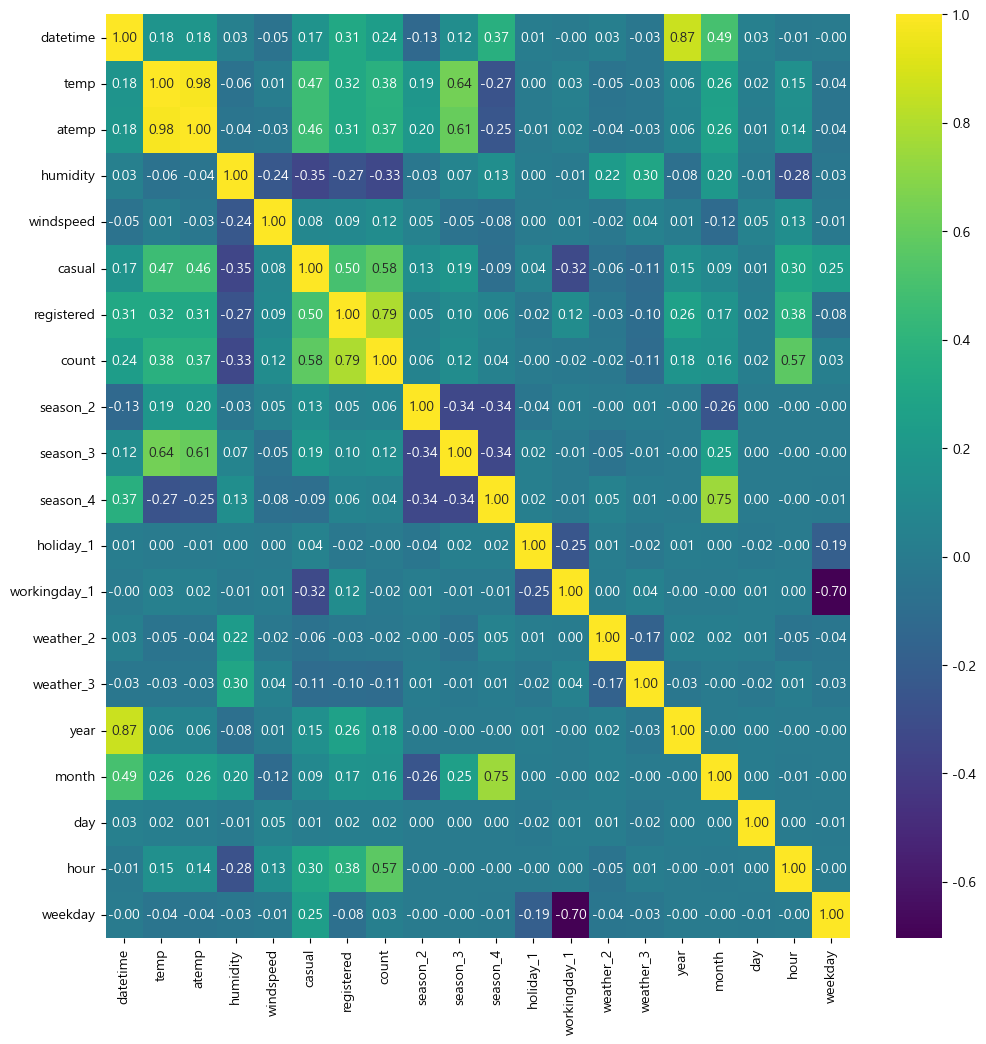

In [36]:
# 히트맵
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='viridis')

In [37]:
# 목표 변수 기준으로 상관관계

corr_target_data = corr['count'].sort_values(ascending=False)
corr_target_data

count           1.000000
registered      0.792133
casual          0.579068
hour            0.570633
temp            0.376682
atemp           0.372254
datetime        0.237444
year            0.178212
month           0.163805
season_3        0.119958
windspeed       0.117463
season_2        0.059064
season_4        0.038043
weekday         0.027318
day             0.019014
holiday_1      -0.001225
workingday_1   -0.015350
weather_2      -0.019171
weather_3      -0.111516
humidity       -0.333226
Name: count, dtype: float64

상관관계 높은 순

- registered : 등록된 사용자 수

- casual : 등록되지 않은 사용자 수

 **** count는 registered와 casual의 합이므로 상관관계가 높게 나오는 것은 구조적으로 당연한 것

- hour : 시간대

- temp : 실측온도

- atemp : 체감온도

- humidity : 습도 (음의 상관관계)




    연도별, 월별, 풍속, 날씨, 평일 vs 휴일 은 추가 확인

season은 월별로 대체 가능

day는 평일 vs 휴일로 대체 가능

###  2. 시간대별 대여량 분석

In [38]:
# 시간대별 평균 대여량

analysis_df['hour'] = analysis_df['datetime'].dt.hour

hour_mean = analysis_df.groupby('hour', observed=False)['count'].mean()
hour_mean


hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: count, dtype: float64

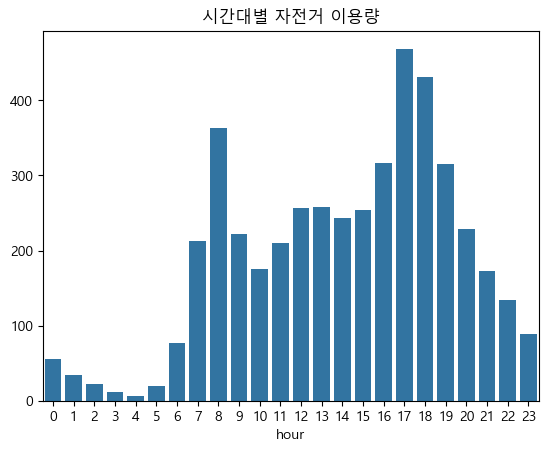

In [39]:
# 시각화
barplot_pattern(analysis_df, 'hour', target='count', title='시간대별 자전거 이용량')

- 상대적으로 출퇴근 시간에 이용자들이 많은 것을 알 수 있다.

### 3. 온도별 대여량 분석

In [40]:
# 실제 온도 구간화  
analysis_df['temp_group'] = pd.cut(
    analysis_df['temp'],
    bins=[-10, 0, 10, 20, 30, 40],
    labels=['0이하', '0~10', '10~20', '20~30', '30이상']
)

temp_mean = analysis_df.groupby('temp_group', observed=False)['count'].mean()
temp_mean


temp_group
0이하             NaN
0~10      73.185862
10~20    150.465053
20~30    223.411398
30이상     334.306516
Name: count, dtype: float64

C:\Users\wina0\AppData\Local\Temp\ipykernel_11692\912854953.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean = df.groupby(group_col)[target].mean()


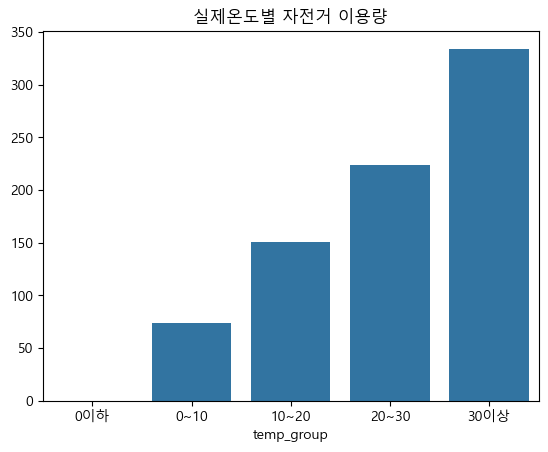

In [41]:
# 시각화
barplot_pattern(analysis_df, 'temp_group', target='count', title="실제온도별 자전거 이용량")

In [42]:
# 체감 온도 구간화  
analysis_df['atemp_group'] = pd.cut(
    analysis_df['atemp'],
    bins=[-10, 0, 10, 20, 30, 40],
    labels=['0이하', '0~10', '10~20', '20~30', '30이상']
)

atemp_mean = analysis_df.groupby('atemp_group', observed=False)['count'].mean()
atemp_mean


atemp_group
0이하             NaN
0~10      67.329289
10~20    125.206462
20~30    179.412210
30이상     290.191229
Name: count, dtype: float64

C:\Users\wina0\AppData\Local\Temp\ipykernel_11692\912854953.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean = df.groupby(group_col)[target].mean()


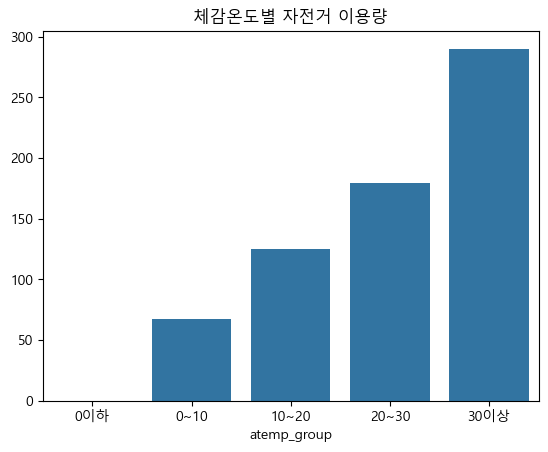

In [43]:
# 시각화
barplot_pattern(analysis_df, 'atemp_group', target='count', title="체감온도별 자전거 이용량")

- 실제 온도와 체감 온도가 이용 평균에 미치는 영향은 비슷함 -> 모델 학습시 한개만 적용 예정
- 온도가 낮을 때보다 높을 때, 이용자가 많은 것을 확인

### 4. 습도별 대여량 분석

In [44]:
# 습도 구간화
analysis_df['humidity_group'] = pd.cut(
    analysis_df['humidity'],
    bins=[0, 30, 60, 100],
    labels=['습도 낮음', '습도 중간', '습도 높음']
)

humidity_mean = analysis_df.groupby('humidity_group', observed=False)['count'].mean()
humidity_mean


humidity_group
습도 낮음    292.291489
습도 중간    236.836306
습도 높음    146.371745
Name: count, dtype: float64

C:\Users\wina0\AppData\Local\Temp\ipykernel_11692\912854953.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean = df.groupby(group_col)[target].mean()


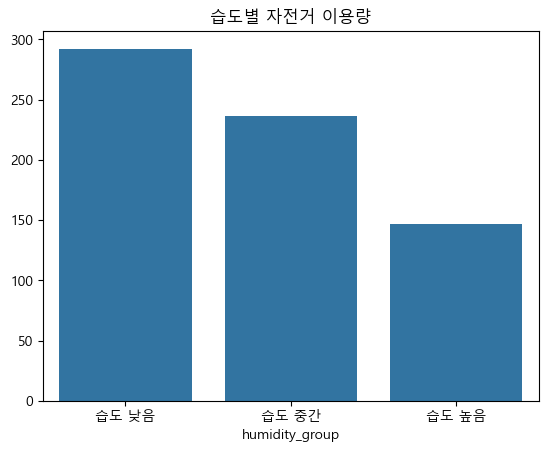

In [45]:
# 시각화
barplot_pattern(analysis_df, 'humidity_group', target='count', title="습도별 자전거 이용량")

- 상대적으로 습도가 낮을 때, 이용자가 많은 것을 확인

## 5. 연도별 대여량 분석

In [46]:
# 연도별 평균 대여량

year_mean = analysis_df.groupby('year', observed=False)['count'].mean()
year_mean 


year
2011    144.223349
2012    238.560944
Name: count, dtype: float64

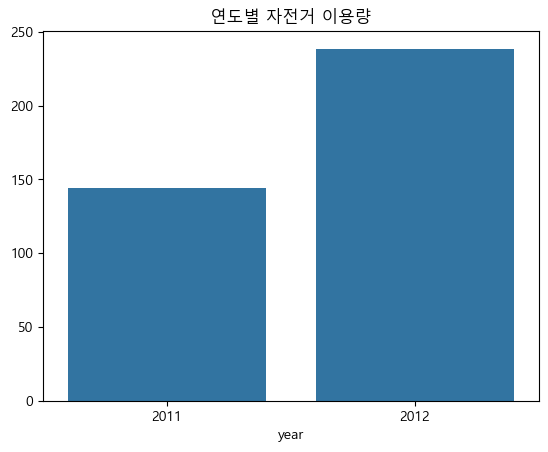

In [47]:
# 시각화
barplot_pattern(analysis_df, 'year', target='count', title="연도별 자전거 이용량")

-> 2012년에 이용자들이 더 많았음.

## 6. 월별 대여량 분석

In [48]:
# 월별 평균 대여량

month_mean = analysis_df.groupby('month', observed=False)['count'].mean()
month_mean


month
1      90.366516
2     110.003330
3     148.169811
4     184.160616
5     219.459430
6     242.031798
7     235.325658
8     234.118421
9     233.805281
10    227.699232
11    193.677278
12    175.614035
Name: count, dtype: float64

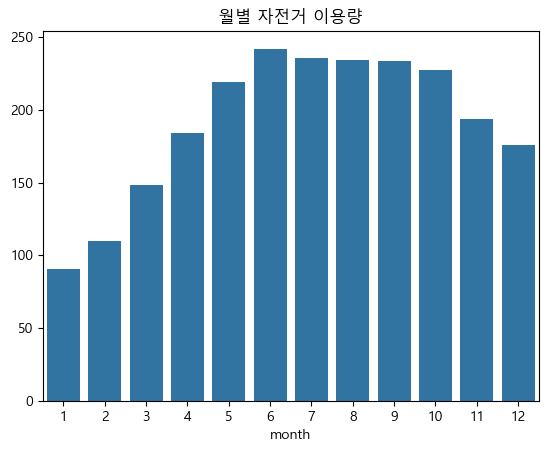

In [49]:
# 시각화
barplot_pattern(analysis_df, 'month', target='count', title="월별 자전거 이용량")

- 겨울보다 여름~가을에 상대적으로 이용자가 많음.

## 7. 풍속별 대여량 분석

<Axes: xlabel='windspeed', ylabel='count'>

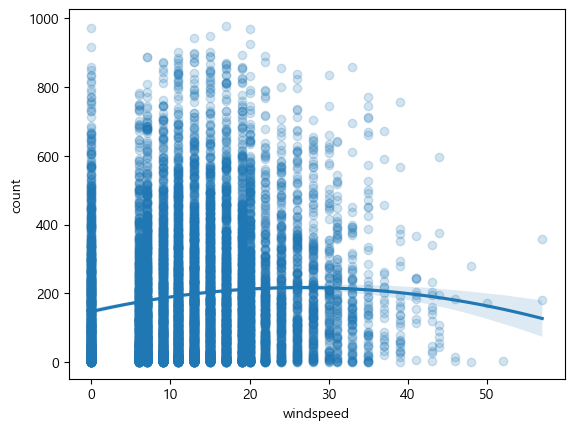

In [50]:
# 추세선 시각화
sns.regplot(
    data=analysis_df,
    x='windspeed',
    y='count',
    order=2,
    scatter_kws={'alpha':0.2}
)

- 바람이 거의 없을 때보다 바람이 적당할 때 대여량이 많음

- 풍속이 강해지면 대여량이 줄어듬

## 8. 날씨별 대여량 분석

In [51]:
# 날씨별 대여량
weather_mean = analysis_df.groupby('weather', observed=False)['count'].mean()
weather_mean

weather
1    205.236791
2    178.955540
3    118.846333
4    164.000000
Name: count, dtype: float64

In [52]:
# weather 4인 데이터량이 부족하여 drop하기
analysis_df = analysis_df[analysis_df['weather'] != 4]
analysis_df['weather'].value_counts()

# 날씨별 대여량
weather_mean = analysis_df.groupby('weather', observed=False)['count'].mean()
weather_mean

weather
1    205.236791
2    178.955540
3    118.846333
Name: count, dtype: float64

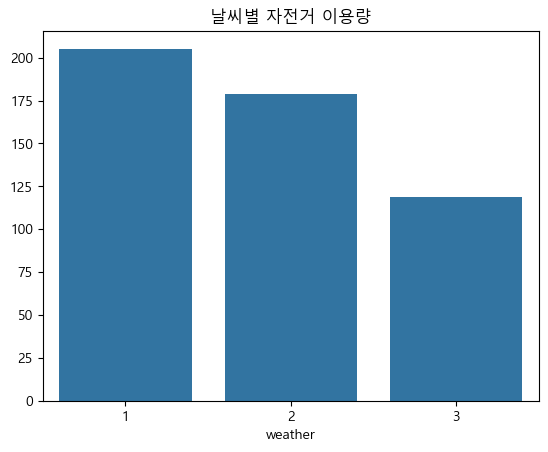

In [53]:
# 시각화
barplot_pattern(analysis_df, 'weather', target='count', title="날씨별 자전거 이용량")

- 날씨가 좋지 않을때보다 날씨가 좋을때 대여량이 높음.

- 폭우/ 폭설시에는 이용을 거의 안함.

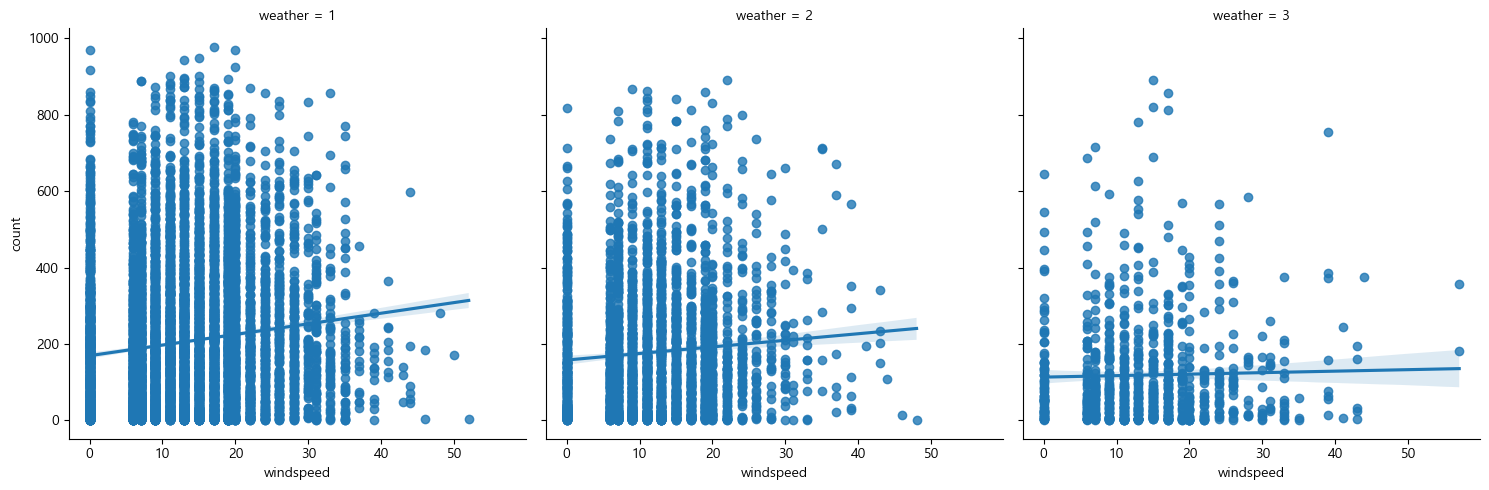

In [54]:
# 바람에 대하여 교란 변수(날씨)를 통제하여 시각화
sns.lmplot(
    data=analysis_df,
    x='windspeed',
    y='count',
    col='weather'
)

- 풍속은 날씨 상태와 상호작용하는 변수로 작용하여, 날씨가 안좋으면 바람과 대여량의 관계는 줄어듬.

## 9. 평일과 휴일별 대여량 분석

In [55]:
# 평일과 휴일별 평균 대여량
holiday_mean = analysis_df.groupby('holiday', observed=False)['count'].mean()
holiday_mean


holiday
0    191.744278
1    185.877814
Name: count, dtype: float64

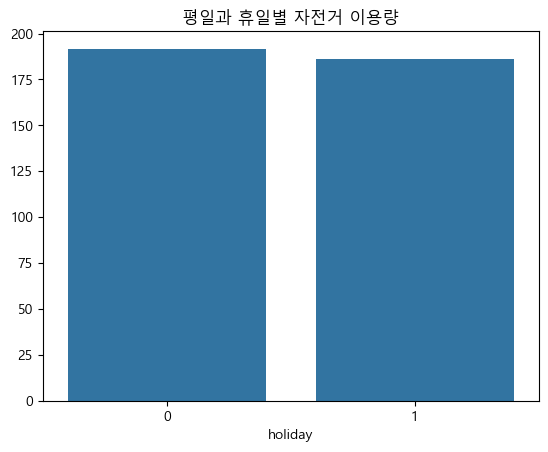

In [56]:
# 시각화
barplot_pattern(analysis_df, 'holiday', target='count', title="평일과 휴일별 자전거 이용량")

- 유의미한 차이 없음

# 4. 데이터 모델링

### 1. 학습 데이터 정리

In [57]:
# 학습 데이터 정리

X = train_encoded_df.drop(columns=['datetime', 'casual', 'registered', 'count'])
y = train_encoded_df['count']

print(X.shape)
print(y.shape)

# 테스트셋 분리(20 : 80)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=5)



(10885, 16)
(10885,)


### 2. 다중 선형 회귀

In [58]:
# 다중 선형 회귀 모델 학습
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# 예측
y_train_linear_pred = linear_model.predict(X_train)
y_valid_linear_pred = linear_model.predict(X_valid)

train_rmsle_linear = rmsle(y_train, y_train_linear_pred)
valid_rmsle_linear = rmsle(y_valid, y_valid_linear_pred)

# RMSLE 평가
print(f"훈련 RMSLE= {train_rmsle_linear:.4f}, 검증 RMSLE= {valid_rmsle_linear:.4f}, 차이= {valid_rmsle_linear-train_rmsle_linear:.4f}")

훈련 RMSLE= 0.9646, 검증 RMSLE= 0.9853, 차이= 0.0207


-> 다중선형회귀의 결과값은 다른 모델과 비교용

### 3. 다항 회귀

In [59]:
results_poly = []

for i in [2, 3]:

    # 다항 변환
    poly = PolynomialFeatures(i)
    X_train_poly = poly.fit_transform(X_train)
    X_valid_poly = poly.transform(X_valid)

    # 다항회귀 모델 학습
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # 예측
    y_train_pred = model.predict(X_train_poly)
    y_valid_pred = model.predict(X_valid_poly)

    # RMSLE 평가
    train_rmsle = rmsle(y_train, y_train_pred)
    valid_rmsle = rmsle(y_valid, y_valid_pred)

    # 결과 저장
    results_poly.append({
        'degree': i,
        'train_rmsle': train_rmsle,
        'valid_rmsle': valid_rmsle
    })

    print(f'차수={i} | 훈련 RMSLE={train_rmsle:.4f}, 검증 RMSLE={valid_rmsle:.4f}, 차이 = {valid_rmsle-train_rmsle:.4f}')

차수=2 | 훈련 RMSLE=0.8027, 검증 RMSLE=0.8229, 차이 = 0.0202
차수=3 | 훈련 RMSLE=0.6888, 검증 RMSLE=0.7481, 차이 = 0.0594


-> 2차는 다중 선형회귀 모델보다 좋아졌고, 훈련 결과와 검증 결과의 차이가 거의 없음

-> 3차는 모델은 더 좋아졌으나, 훈련 결과와 검증 결과가 차이가 나기 시작

-> 4차는 모델 복잡도가 증가해 과적합 가능성이 높아, 실험 대상에서 제외

### 3. 로지스틱회귀 

현재 회귀문제이므로 생략

### 4. 정규화

#### 1. L2 정규화

In [60]:

results_l2 = []

for i in [2, 3]:
    for a in [0.1, 1, 10, 50, 100]:

        # 다항 변환
        poly_L2 = PolynomialFeatures(i)
        X_train_poly_L2 = poly_L2.fit_transform(X_train)
        X_valid_poly_L2 = poly_L2.transform(X_valid)

        # Ridge 모델
        ridge_model = Ridge(alpha=a, max_iter=5000)
        ridge_model.fit(X_train_poly_L2, y_train)

        # 예측
        y_train_pred_L2 = ridge_model.predict(X_train_poly_L2)
        y_valid_pred_L2 = ridge_model.predict(X_valid_poly_L2)

        # RMSLE 계산
        train_rmsle = rmsle(y_train, y_train_pred_L2)
        valid_rmsle = rmsle(y_valid, y_valid_pred_L2)

        # 결과 저장
        results_l2.append({
            'degree': i,
            'alpha': a,
            'train_rmsle': train_rmsle,
            'valid_rmsle': valid_rmsle,
        })

        print(f'차수={i}, 알파={a}, train={train_rmsle:.4f}, valid={valid_rmsle:.4f}, 차이={valid_rmsle-train_rmsle:.4f}')


차수=2, 알파=0.1, train=0.8057, valid=0.8229, 차이=0.0172
차수=2, 알파=1, train=0.8061, valid=0.8232, 차이=0.0172
차수=2, 알파=10, train=0.8065, valid=0.8239, 차이=0.0174
차수=2, 알파=50, train=0.8072, valid=0.8247, 차이=0.0175
차수=2, 알파=100, train=0.8076, valid=0.8252, 차이=0.0175
차수=3, 알파=0.1, train=0.6942, valid=0.7411, 차이=0.0469
차수=3, 알파=1, train=0.6962, valid=0.7393, 차이=0.0432
차수=3, 알파=10, train=0.6994, valid=0.7378, 차이=0.0384
차수=3, 알파=50, train=0.7026, valid=0.7368, 차이=0.0343
차수=3, 알파=100, train=0.7041, valid=0.7367, 차이=0.0325


#### 2. L1 정규화

In [61]:
results_l1 = []

def L1check(i,a):
    # 다항 변환
    poly_L1 = PolynomialFeatures(i)
    X_train_poly_L1 = poly_L1.fit_transform(X_train)
    X_valid_poly_L1 = poly_L1.transform(X_valid)

    # Lasso 모델 (L1)
    lasso_model = Lasso(alpha=a, max_iter=10000, tol=1e-2)
    lasso_model.fit(X_train_poly_L1, y_train)

    # 예측
    y_train_pred_L1 = lasso_model.predict(X_train_poly_L1)
    y_valid_pred_L1 = lasso_model.predict(X_valid_poly_L1)

    # RMSLE 계산
    train_rmsle = rmsle(y_train, y_train_pred_L1)
    valid_rmsle = rmsle(y_valid, y_valid_pred_L1)

    results_l1.append({
        'degree': i,
        'alpha': a,
        'train_rmsle': train_rmsle,
        'valid_rmsle': valid_rmsle
    })

    print(f'차수={i}, 알파={a}, train={train_rmsle:.4f}, valid={valid_rmsle:.4f}, 차이={valid_rmsle-train_rmsle:.4f}')


for i in [2, 3]:
    if i == 2:
        for a in [0.1, 1, 10, 50, 100]:
            L1check(i, a)
    else:
        for a in [10, 50, 100]:   # L2 결과를 보고, L1 에서의 3차는 큰 알파값만 실험함.
            L1check(i,a)    


차수=2, 알파=0.1, train=0.8263, valid=0.8397, 차이=0.0134
차수=2, 알파=1, train=0.8319, valid=0.8427, 차이=0.0108
차수=2, 알파=10, train=0.8712, valid=0.8872, 차이=0.0160
차수=2, 알파=50, train=0.9722, valid=0.9966, 차이=0.0244
차수=2, 알파=100, train=0.9772, valid=1.0018, 차이=0.0246
차수=3, 알파=10, train=0.7645, valid=0.7803, 차이=0.0159
차수=3, 알파=50, train=0.7963, valid=0.8121, 차이=0.0158
차수=3, 알파=100, train=0.8212, valid=0.8365, 차이=0.0153


## 5. 모델 선정

In [62]:
# 다중 선형 회귀 DF화
linear_df = pd.DataFrame([{
    'model': 'Linear',
    'degree': 1,
    'regularization': 'None',
    'alpha': 'None',
    'train_rmsle': train_rmsle_linear,
    'valid_rmsle': valid_rmsle_linear
}])

# 디항 선형 회귀 DF화
poly_df = pd.DataFrame(results_poly)
poly_df['model'] = 'Polynomial'
poly_df['regularization'] = 'None'
poly_df['alpha'] = 'None'

# L2 DF화
ridge_df = pd.DataFrame(results_l2)
ridge_df['model'] = 'Polynomial'
ridge_df['regularization'] = 'L2'

# L1 DF화
lasso_df = pd.DataFrame(results_l1)
lasso_df['model'] = 'Polynomial'
lasso_df['regularization'] = 'L1'

# 데이터 합치기
all_results = pd.concat([linear_df, poly_df, ridge_df, lasso_df], ignore_index=True)

# 훈련rmsle와 검증rmsle 차이 추가
all_results["diff"] = all_results['valid_rmsle']-all_results['train_rmsle']

# 정렬하기
all_results[['model', 'regularization', 'degree', 'alpha', 'train_rmsle', 'valid_rmsle', 'diff']].sort_values('valid_rmsle')


,model,regularization,degree,alpha,train_rmsle,valid_rmsle,diff
12,Polynomial,L2,3,100.0,0.704145,0.736654,0.032509
11,Polynomial,L2,3,50.0,0.702588,0.736841,0.034253
10,Polynomial,L2,3,10.0,0.699410,0.737830,0.038420
9,Polynomial,L2,3,1.0,0.696160,0.739332,0.043172
8,Polynomial,L2,3,0.1,0.694193,0.741134,0.046941
2,Polynomial,None,3,None,0.688754,0.748108,0.059354
18,Polynomial,L1,3,10.0,0.764462,0.780317,0.015854
19,Polynomial,L1,3,50.0,0.796304,0.812080,0.015775
1,Polynomial,None,2,None,0.802673,0.822912,0.020239
3,Polynomial,L2,2,0.1,0.805717,0.822949,0.017232


    -> 선택 모델 : 다항회귀 모델 + 3차 + 알파값100 + L2 정규화 

## 6. 하이퍼 파타미터 탐색 (Optuna)

In [ ]:
# Optuna
def objective(trial):

    # 탐색할 하이퍼파라미터
    degree = trial.suggest_int('degree', 2, 3)
    alpha = trial.suggest_float('alpha', 0.01, 100, log=True)

    # 다항 변환
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train)
    X_valid_poly = poly.transform(X_valid)

    # Ridge 모델
    model = Ridge(alpha)
    model.fit(X_train_poly, y_train)

    # 예측
    y_valid_pred = model.predict(X_valid_poly)

    return rmsle(y_valid, y_valid_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print(f'study.best_params: {study.best_params}')
print(f'study.best_value: {study.best_value}')


[I 2026-01-19 16:35:09,127] A new study created in memory with name: no-name-7b4fc08d-bbb5-4616-838d-bcae4420cb33
c:\Users\wina0\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\wina0\AppData\Local\Temp\ipykernel_11692\2584231288.py:33: RuntimeWarning: overflow encountered in exp
  y_pred = np.exp(y_pred)
[I 2026-01-19 16:35:09,160] Trial 0 finished with value: inf and parameters: {'degree': 2, 'alpha': 2.4229156285972757}. Best is trial 0 with value: inf.
c:\Users\wina0\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\wina0\AppData\Local\Temp\ipykernel_11692\2584231288.py:33: RuntimeWarning: overflow encountered in exp
  y_pred = np.exp(y_pred)
[I 2026-01-19 16:35:09,185] Trial 1 finished with value:

study.best_params: {'degree': 2, 'alpha': 2.4229156285972757}
study.best_value: inf


GridSearch는 전수 탐색이라 비효율적이라 판단하여 Optuna를 사용함.

처음부터 train데이터와 test데이터가 분리되어 있어

OptunaSearchCV 대신 create_study 기반으로 objective 함수를 정의하여 사용했음.

# 5. 최종 test

In [64]:
# test 데이터 정리
X_test = test_encoded_df.select_dtypes(exclude=['datetime64'])

# train 기준으로 test 컬럼 맞추기
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# 1train + valid 합치기 (최종 학습용)
X_train_final = np.vstack([X_train, X_valid])
y_train_final = np.concatenate([y_train, y_valid])

# 최종 파라미터 - Optuna 결과 반영
final_degree = study.best_params['degree']
final_alpha = study.best_params['alpha']

# 다항 변환 
poly = PolynomialFeatures(final_degree)
X_train_final_poly = poly.fit_transform(X_train_final)
X_test_poly = poly.transform(X_test)

# 최종 L2 학습
final_model = Ridge(alpha=final_alpha)
final_model.fit(X_train_final_poly, y_train_final)

# test 예측
y_test_pred_log = final_model.predict(X_test_poly)
y_test_pred = np.expm1(y_test_pred_log)

# 음수는 0으로 클리핑
y_test_pred = np.maximum(0, y_test_pred)

# 결과 확인

print("음수 개수:", (y_test_pred < 0).sum())
print("NaN 개수:", np.isnan(y_test_pred).sum())
print("inf 개수:", np.isinf(y_test_pred).sum())

음수 개수: 0
NaN 개수: 0
inf 개수: 0


c:\Users\wina0\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2684: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(


로그변환을 이용하여 일부 음수 예측이 발생해 물리적으로 불가능한 값은 0으로 보정하였음.

In [65]:
# 기존 test_df 확인하기
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,-1.228414,-1.450292,-0.305883,3.295937
1,2011-01-20 01:00:00,1,0,1,1,-1.228414,-1.182421,-0.305883,0.000000
2,2011-01-20 02:00:00,1,0,1,1,-1.228414,-1.182421,-0.305883,0.000000
3,2011-01-20 03:00:00,1,0,1,1,-1.228414,-1.271515,-0.305883,2.485023
4,2011-01-20 04:00:00,1,0,1,1,-1.228414,-1.271515,-0.305883,2.485023


In [66]:
# test_df에 최종 예측값 추가하기
test_df['pred_count'] = y_test_pred

In [67]:
# 최종 결과 확인
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,pred_count
0,2011-01-20 00:00:00,1,0,1,1,-1.228414,-1.450292,-0.305883,3.295937,3.713172
1,2011-01-20 01:00:00,1,0,1,1,-1.228414,-1.182421,-0.305883,0.000000,6.696557
2,2011-01-20 02:00:00,1,0,1,1,-1.228414,-1.182421,-0.305883,0.000000,9.981088
3,2011-01-20 03:00:00,1,0,1,1,-1.228414,-1.271515,-0.305883,2.485023,13.151469
4,2011-01-20 04:00:00,1,0,1,1,-1.228414,-1.271515,-0.305883,2.485023,18.284333


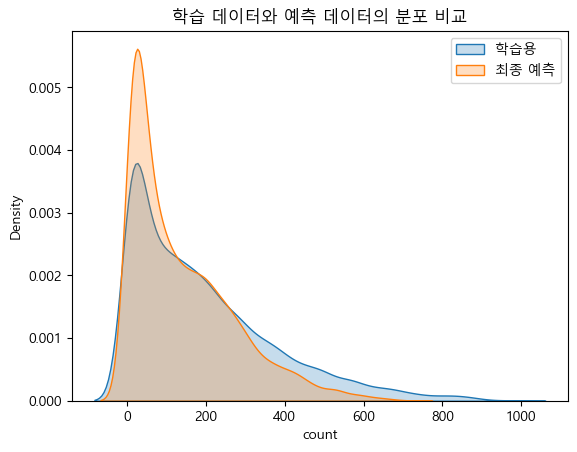

In [68]:
# 학습데이터의 목표변수와 모델을 이용하여 찾은 최종 예측값 분포 확인하기

sns.kdeplot(np.expm1(train_df['count']), label='학습용', fill=True)
sns.kdeplot(test_df['pred_count'], label='최종 예측', fill=True)
plt.legend()
plt.title("학습 데이터와 예측 데이터의 분포 비교")
plt.show()

# 6. 결론

다중선형회귀를 기준으로 다항회귀와 정규화를 적용하여,

valid_rmsle 기준으로 Optuna를 활용해

    다항회귀 3차 + L2 Ridge(알파값=100) 모델을 최종 선택했다.

초반에 나눴던 train데이터와 valid데이터를 통합한 뒤

선택한 모델로 재학습하고 test 데이터에 대한 최종 예측을 수행하였고,

음수값이 일부 발생하였으나, 물리적으로 공유 자전거 수요에서 음수값은 나올 수 없으므로

0으로 보정하고, 결측값이나 무한대값이 없음을 확인하였다.

최종적으로 학습 데이터와 예측 데이터의 분포를 비교하니, 비슷한 분포를 보였다.